# 02 Einfachere Segmentierung

Hartwig hatt in seiner E-Mail einen Schnellschuss für eine einfachere Segmentierung. Mal sehen, was die taugt.

Zitat: "Objekte habe ich über einen "adaptiven" Grenzwert in der IR108-BT maskiert und gelabelt, erst lokale Minima bestimmt (mit Tiefe >8K oder so, siehe skimage.extrema.h_minima), dann das Objekt mit einem Grenzwert thresh =  np.max((tmin+5.0,260.0)) maskiert und gelabelt."

In [36]:
import xarray as xr
from skimage.morphology import extrema
from skimage.measure import label
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

import sys
sys.path.append("/vols/satellite/home/lenk/utils/tracking")
import object_tracking as ot

from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import matplotlib as mpl
import datetime as dt

In [2]:
data_folder = "/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/"

In [3]:
sat_data = xr.open_dataset("{}/msg2-20130618-l15msg.nc".format(data_folder))

In [4]:
#ir108_subset = np.array([sat_data.ir108.data[i] for i in range(19,28)])
ir108_subset = sat_data.ir108.data.copy()

In [5]:
ir108_subset.shape

(48, 51, 101)

Text(0.01, 0.5, 'latitutde / °N')

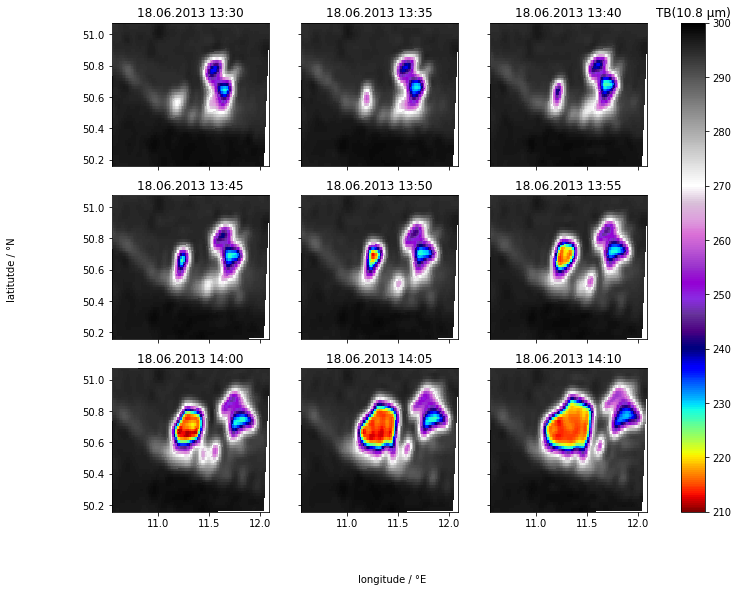

In [6]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,ir in enumerate(ir108_subset[18:27]):
    p = axs[i].pcolormesh(sat_data.lon.data,sat_data.lat.data,ir,vmin=210,vmax=300,cmap=emap)
    axs[i].set_title(pd.Timestamp(sat_data.time.data[i+18]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'TB(10.8 µm)')

# Make common axis labels
fig.text(0.45, 0.02,u'longitude / °E', va='center', ha='center')
fig.text(0.01, 0.5, u'latitutde / °N', va='center', ha='center', rotation='vertical')

In [17]:
lokmin = np.array([extrema.h_minima(ndi.d,8) for d in ir108_subset])

In [18]:
lokmin_labeled = np.array([label(lm) for lm in lokmin])

IndexError: index 9 is out of bounds for axis 0 with size 9

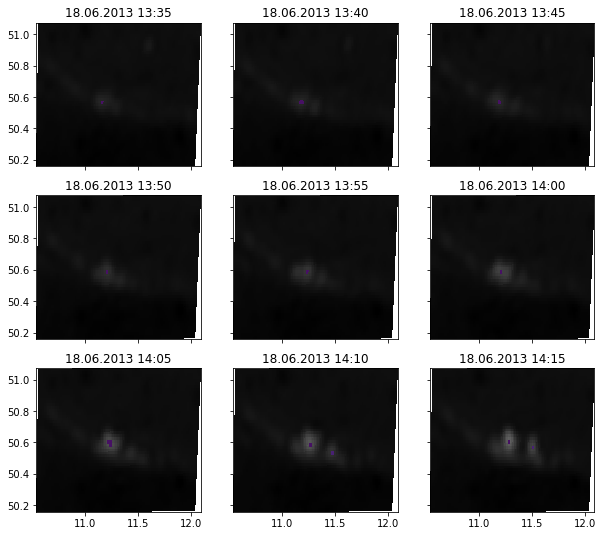

In [19]:
fig,ax = plt.subplots(3,3,figsize=(10,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(lokmin_labeled):
    axs[i].pcolormesh(sat_data.lon.data,
                      sat_data.lat.data,
                      ir108_subset[i],vmin=210,vmax=300,cmap='gray_r')
    p = axs[i].pcolormesh(sat_data.lon.data,
                          sat_data.lat.data,
                          np.ma.masked_less(lm,1),vmin=0,vmax=22)
    axs[i].set_title(pd.Timestamp(sat_data.time.data[i+19]).strftime("%d.%m.%Y %H:%M"))
    
# Make common axis labels
fig.text(0.45, 0.02,u'longitude / °E', va='center', ha='center')
fig.text(0.01, 0.5, u'latitutde / °N', va='center', ha='center', rotation='vertical')   
plt.suptitle(u"Lokale Minima, h\u2009\u2265\u20098")

In [24]:
object_values = {t:{} for t in range(len(ir108_subset))}
object_thresholds = {t:{} for t in range(len(ir108_subset))}

for i, lm in enumerate(lokmin_labeled):
    oids = np.unique(lm)
    oids = oids[oids!=0]
    
    for o in oids:
        lm_loc = np.where(lm==o)
        
        values = ir108_subset[i][lm_loc]
        
        object_values[i][o] = np.unique(values)[0]
        object_thresholds[i][o] = np.max((np.unique(values)[0]+8,240))

In [25]:
object_values

{0: {1: 286.82620000000003},
 1: {1: 286.5512},
 2: {1: 285.7219},
 3: {1: 283.47700000000003},
 4: {1: 280.8903},
 5: {1: 277.3322},
 6: {1: 272.5303},
 7: {1: 269.7866, 2: 282.192},
 8: {1: 265.7627, 2: 275.8099},
 9: {1: 259.53110000000004, 2: 273.9501},
 10: {1: 272.0521},
 11: {1: 269.6225},
 12: {1: 244.6861, 2: 268.2992},
 13: {1: 241.9267, 2: 268.1324, 3: 268.1324, 4: 280.8903},
 14: {1: 233.9546, 2: 267.63, 3: 280.8903, 4: 259.90020000000004, 5: 282.7651},
 15: {1: 232.6139, 2: 277.3322, 3: 248.4179},
 16: {1: 231.2432, 2: 239.05, 3: 275.9633},
 17: {1: 234.74540000000002, 2: 231.2432, 3: 275.3484},
 18: {1: 236.29780000000002, 2: 228.1134, 3: 270.2769},
 19: {1: 237.0601, 2: 229.2706, 3: 258.226},
 20: {1: 236.55290000000002, 2: 226.93280000000001, 3: 240.7431},
 21: {1: 240.02280000000002, 2: 227.8204, 3: 226.6338},
 22: {1: 242.39440000000002, 2: 213.1087, 3: 227.8204, 4: 264.20410000000004},
 23: {1: 228.40480000000002, 2: 214.25330000000002, 3: 258.78790000000004},
 24: {

In [26]:
object_thresholds

{0: {1: 294.82620000000003},
 1: {1: 294.5512},
 2: {1: 293.7219},
 3: {1: 291.47700000000003},
 4: {1: 288.8903},
 5: {1: 285.3322},
 6: {1: 280.5303},
 7: {1: 277.7866, 2: 290.192},
 8: {1: 273.7627, 2: 283.8099},
 9: {1: 267.53110000000004, 2: 281.9501},
 10: {1: 280.0521},
 11: {1: 277.6225},
 12: {1: 252.6861, 2: 276.2992},
 13: {1: 249.9267, 2: 276.1324, 3: 276.1324, 4: 288.8903},
 14: {1: 241.9546, 2: 275.63, 3: 288.8903, 4: 267.90020000000004, 5: 290.7651},
 15: {1: 240.6139, 2: 285.3322, 3: 256.41790000000003},
 16: {1: 240.0, 2: 247.05, 3: 283.9633},
 17: {1: 242.74540000000002, 2: 240.0, 3: 283.3484},
 18: {1: 244.29780000000002, 2: 240.0, 3: 278.2769},
 19: {1: 245.0601, 2: 240.0, 3: 266.226},
 20: {1: 244.55290000000002, 2: 240.0, 3: 248.7431},
 21: {1: 248.02280000000002, 2: 240.0, 3: 240.0},
 22: {1: 250.39440000000002, 2: 240.0, 3: 240.0, 4: 272.20410000000004},
 23: {1: 240.0, 2: 240.0, 3: 266.78790000000004},
 24: {1: 240.0, 2: 240.0, 3: 240.0, 4: 266.601},
 25: {1: 2

In [27]:
obj_labeled = []

for i, ir in enumerate(ir108_subset):
    labels = np.unique(lokmin_labeled[i])[1:]
    
    segmented = np.zeros_like(ir)
    
    for l in labels:
        mask = np.ma.masked_greater(ir,object_thresholds[i][l])
        seg = watershed(ir,lokmin_labeled[i],mask=~mask.mask)
        
        obj_loc = np.where(seg==l)
        
        segmented[obj_loc] = l
    
    obj_labeled.append(segmented)

In [30]:
ds = xr.Dataset({'object_mask': (['time','x', 'y'],  np.array(obj_labeled,dtype='int'))},
                    
                   coords={'time': sat_data.time.data,
                           'lon': (['x', 'y'], sat_data.lon.data),
                           'lat': (['x', 'y'], sat_data.lat.data)})

In [31]:
ds.to_netcdf("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")
ds.close()

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [32]:
object_mask = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")

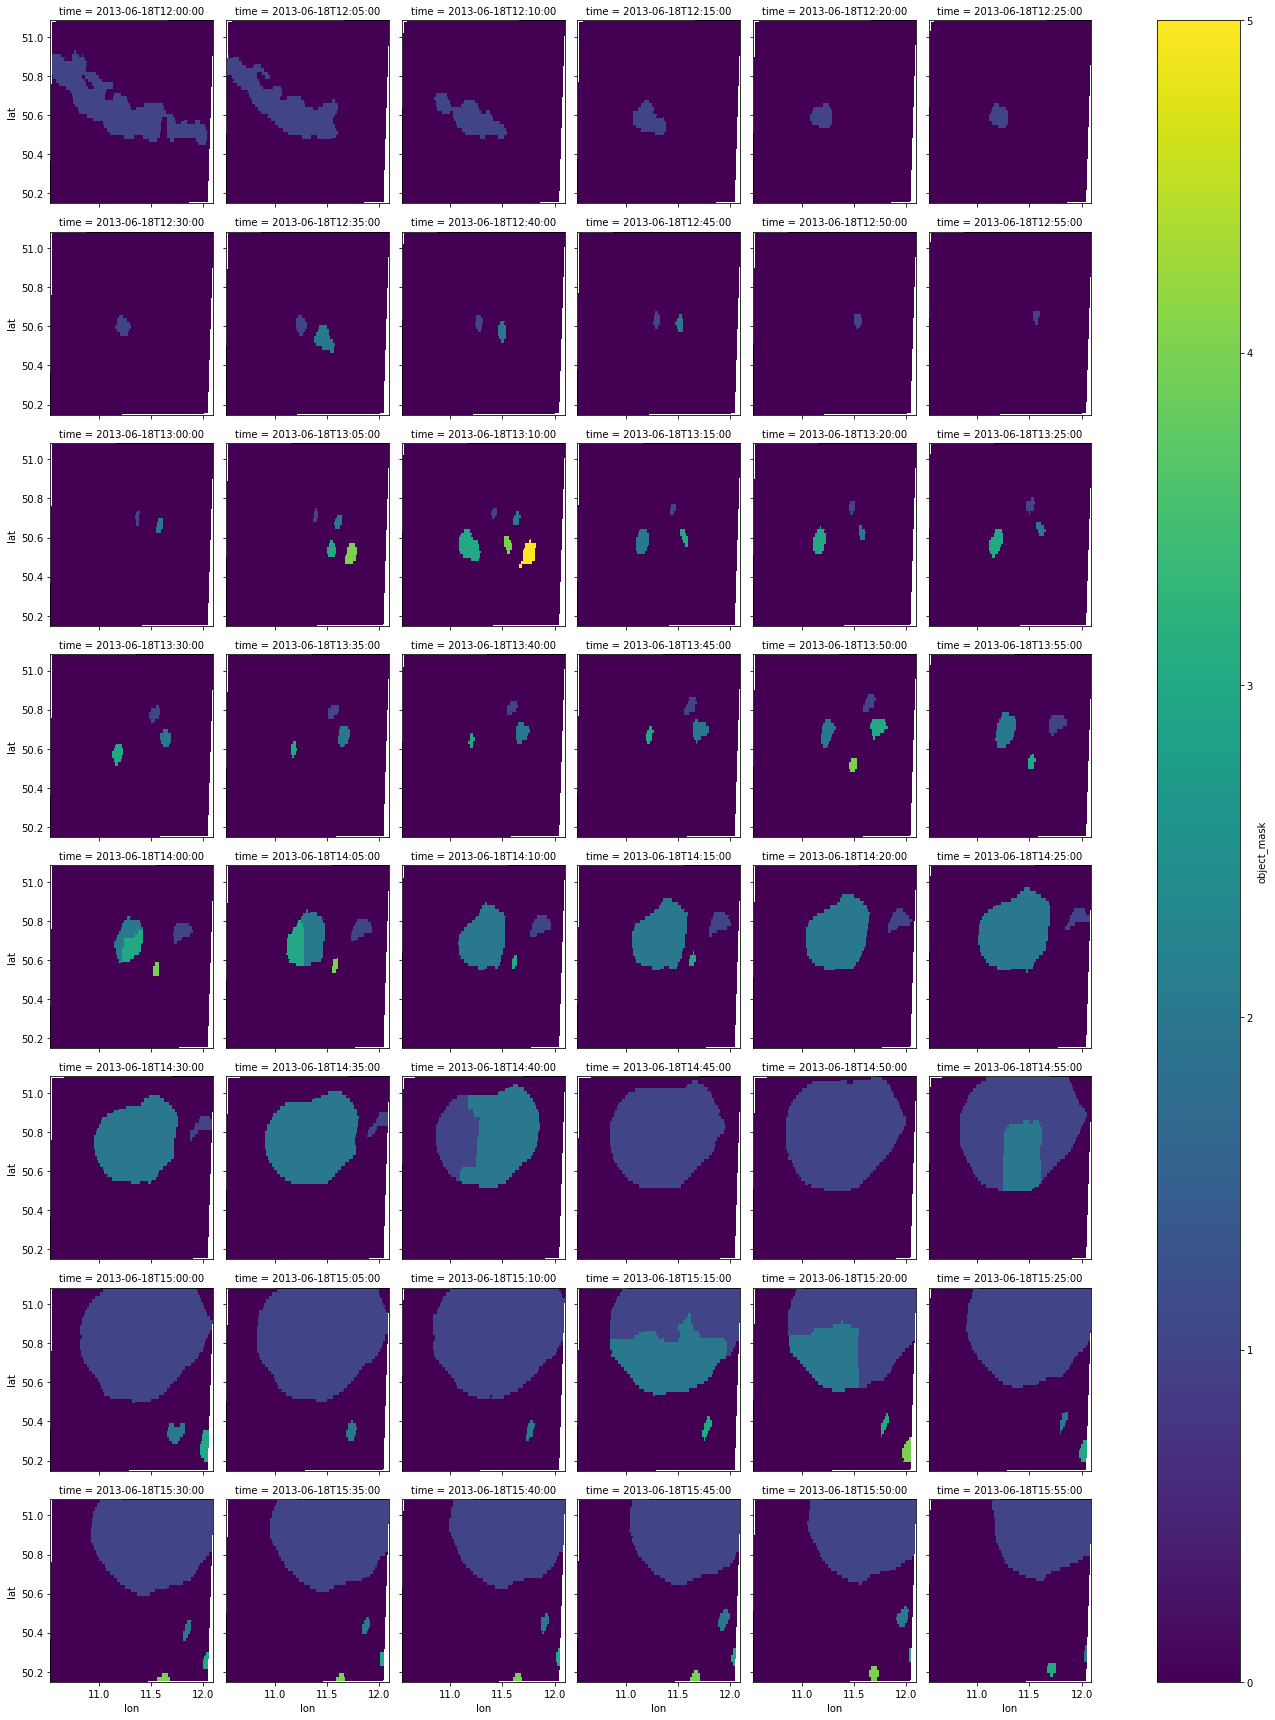

In [33]:
object_mask.object_mask.plot(x='lon',y='lat',col='time',col_wrap=6)

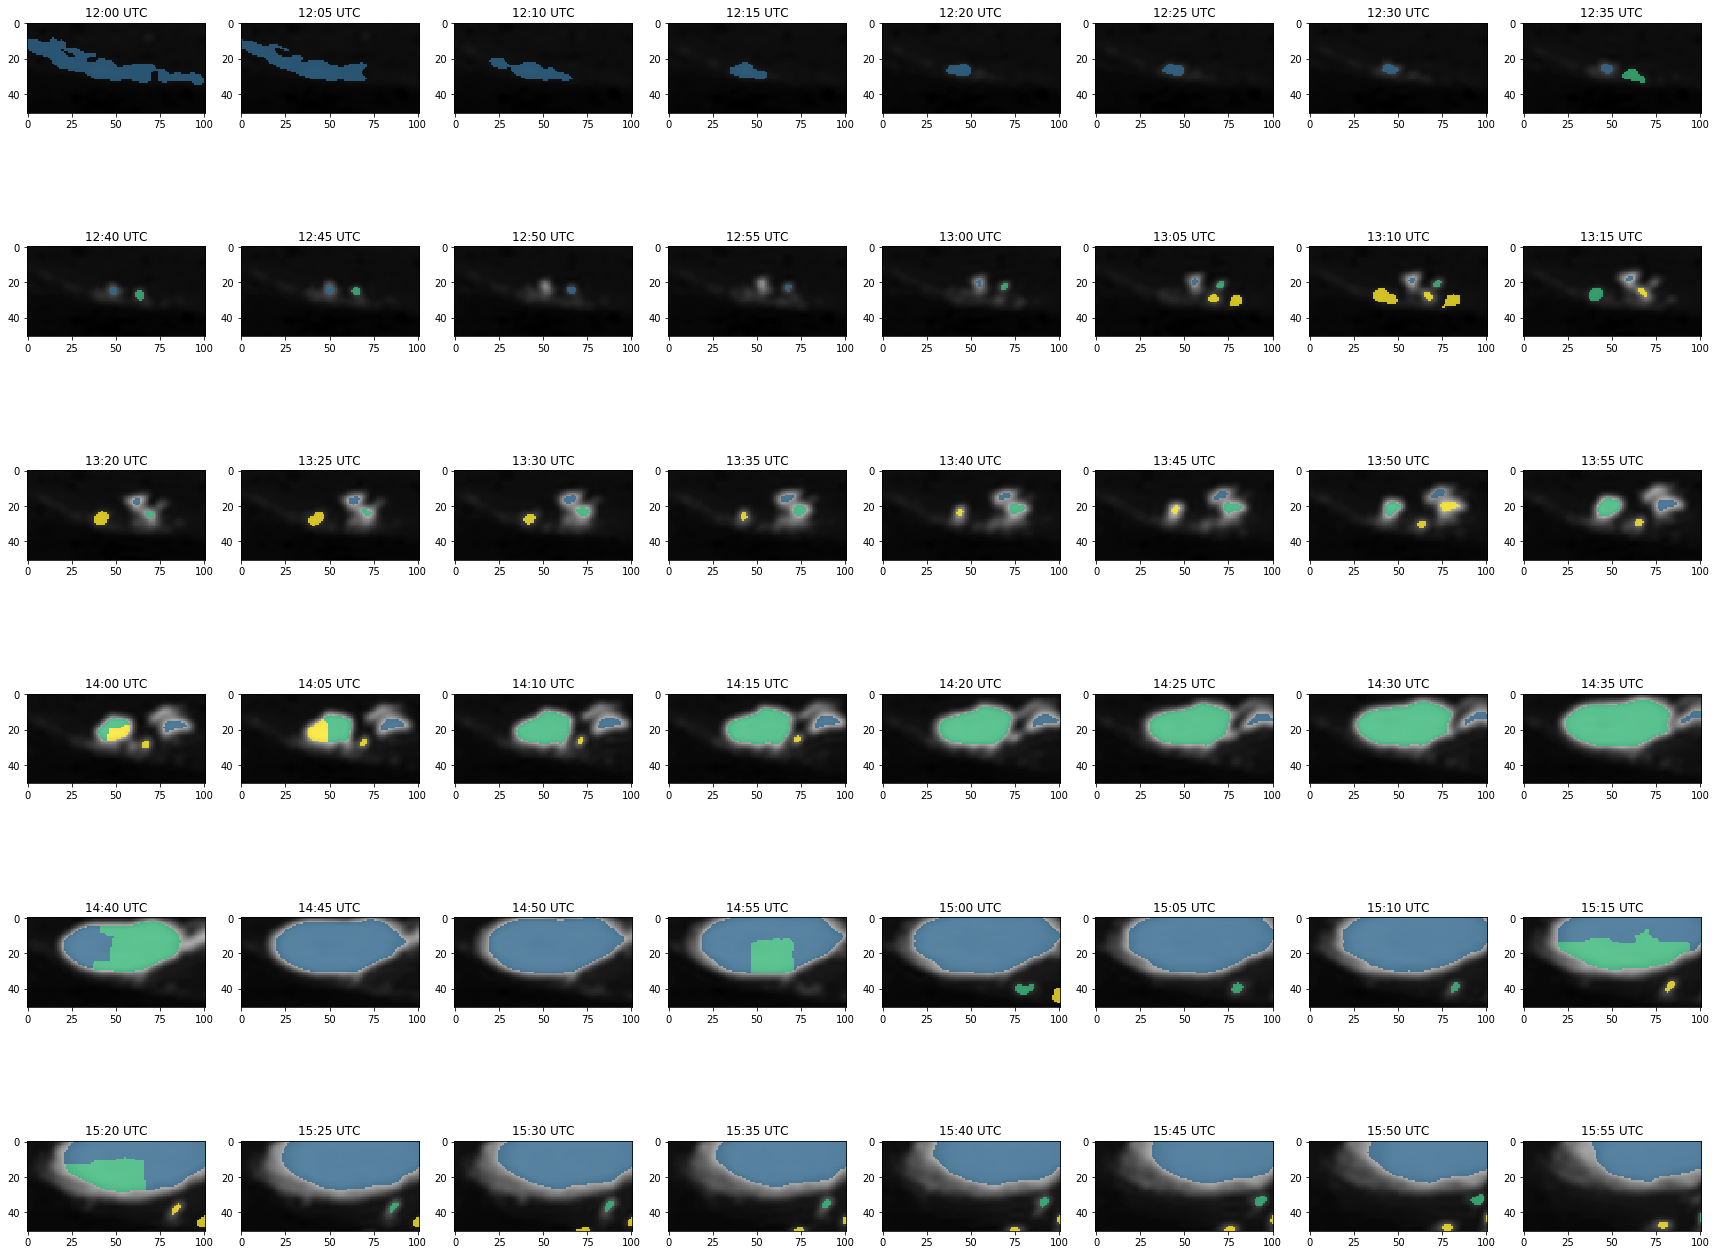

In [34]:
fig,ax = plt.subplots(6,8,figsize=(30,24))
axs = ax. ravel()

for i, obj in enumerate(object_mask.object_mask.data):
    axs[i].imshow(sat_data.ir108.data[i],vmin=210,vmax=300,cmap='gray_r')
    p = axs[i].imshow(np.ma.masked_less(obj,1),alpha=0.8,vmin=0,vmax=3)
    axs[i].set_title(pd.Timestamp(sat_data.time.data[i]).strftime("%H:%M UTC"))

IndexError: index 9 is out of bounds for axis 0 with size 9

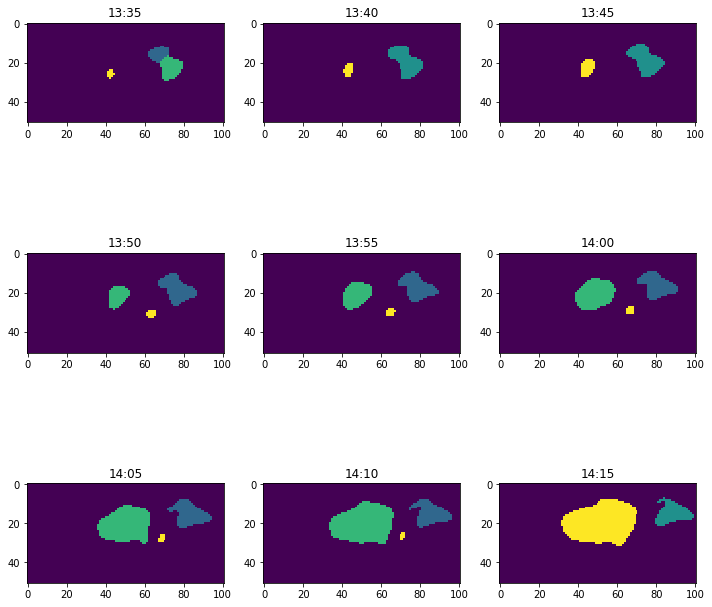

In [57]:
fig,ax = plt.subplots(3,3,figsize=(12,12))
axs = ax.ravel()

for i, obj in enumerate(object_mask.object_mask.data[19:29]):
    axs[i].imshow(obj)
    axs[i].set_title(pd.Timestamp(object_mask.time.data[19:29][i]).strftime("%H:%M"))

In [58]:
connections,objects = ot.generate_graph_from_components(object_mask.object_mask.data[19:29].copy(),
                                                        np.arange(0,10))

In [59]:
objects[1].nodes()

NodeView(('6_0002', '1_0002', '7_0002', '4_0002', '0_0003', '9_0002', '3_0002', '8_0002', '2_0002', '5_0002'))

Dann suchen wir uns doch am besten den Track heraus, der das Objekt enthält, dass 13:55 UTC auslöst.

In [60]:
data_segmented = object_mask.object_mask.data[19:29].copy()

In [61]:
wanted_id = ot.get_wanted_object_id(data_segmented)
target_object_id = '{}_{:04d}'.format(len(data_segmented)//2,wanted_id)

print(target_object_id)

5_0002


In [62]:
wanted_id = ot.get_wanted_object_id(data_segmented)
target_object_id = '{}_{:04d}'.format(len(data_segmented)//2,wanted_id)

# look for the graph wich cointains this object
wanted_object_graph = ot.get_wanted_graph(objects,target_object_id)

# it may be that this is a complex graph, but ideally we only want the
# path of a single cell
wanted_object_graph_sorted = ot.sort_graph_by_timesteps(wanted_object_graph)

object_track = ot.get_main_track(data_segmented,wanted_object_graph_sorted,target_object_id)

# get the objects
wanted_object = ot.get_wanted_objects(data_segmented,object_track)

In [63]:
target_object_id

'5_0002'

In [64]:
wanted_object_graph.nodes()

NodeView(('6_0002', '1_0002', '7_0002', '4_0002', '0_0003', '9_0002', '3_0002', '8_0002', '2_0002', '5_0002'))

IndexError: index 9 is out of bounds for axis 0 with size 9

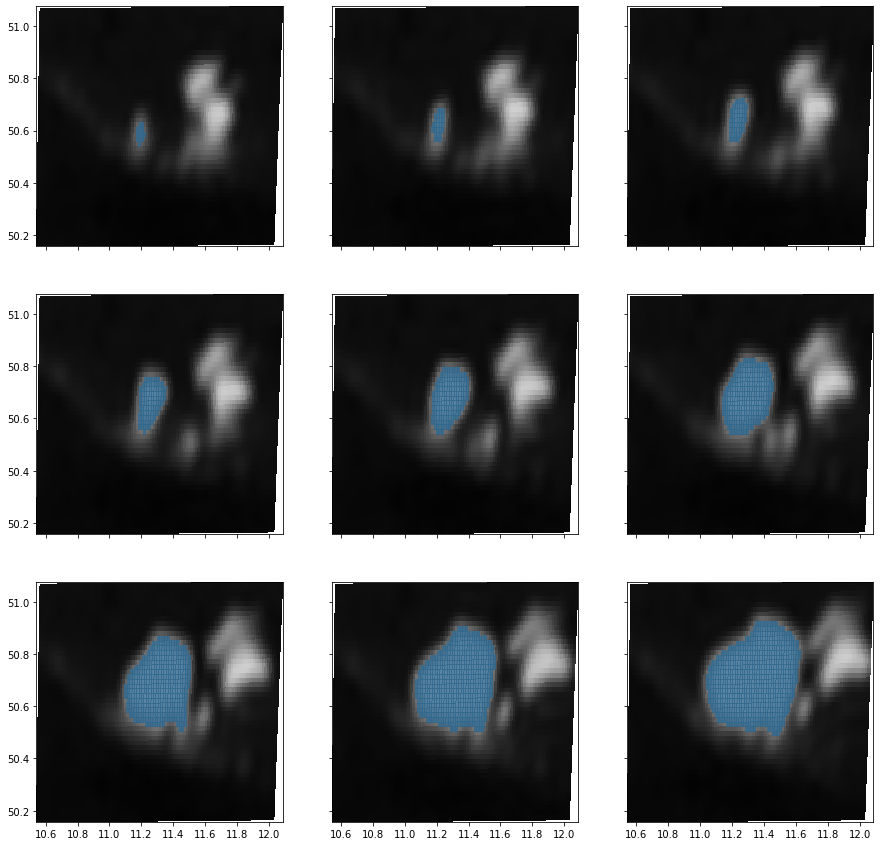

In [65]:
fig,ax = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
axs = ax. ravel()

for i, obj in enumerate(wanted_object):
    axs[i].pcolormesh(sat_data.lon.data,sat_data.lat.data,ir108_subset[19:29][i],vmin=210,vmax=300,cmap='gray_r')
    axs[i].pcolormesh(sat_data.lon.data,sat_data.lat.data,np.ma.masked_less(obj,1),alpha=0.8,vmin=0,vmax=3)

Das passt. Dann extrahieren wir mal die Objektdaten.

In [69]:
cpp_hr_data = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/msg2-20130618-l2cpphr.nc")
cpp_lr_data = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/msg2-20130618-l2cpplr.nc")

In [84]:
list(sat_data.data_vars)[:12]

['vis006',
 'vis008',
 'ir016',
 'ir039',
 'wv062',
 'wv073',
 'ir087',
 'ir097',
 'ir108',
 'ir120',
 'ir134',
 'hrv']

In [ ]:
cpp_lr_vars = list(cpp_hr_data.data_vars)[1:13]

In [89]:
cpp_vars = []

for v in list(cpp_hr_data.data_vars)[1:13]:
    cpp_vars.append("{}_lr".format(v))
    cpp_vars.append("{}_hr".format(v))

In [90]:
fields = list(sat_data.data_vars)[:12] + cpp_vars

In [91]:
fields

['vis006',
 'vis008',
 'ir016',
 'ir039',
 'wv062',
 'wv073',
 'ir087',
 'ir097',
 'ir108',
 'ir120',
 'ir134',
 'hrv',
 'cldmask_lr',
 'cldmask_hr',
 'cot_lr',
 'cot_hr',
 'cot_unc_lr',
 'cot_unc_hr',
 'cre_lr',
 'cre_hr',
 'cre_unc_lr',
 'cre_unc_hr',
 'cwp_lr',
 'cwp_hr',
 'cwp_unc_lr',
 'cwp_unc_hr',
 'cph_lr',
 'cph_hr',
 'cph_pavo_lr',
 'cph_pavo_hr',
 'cth_lr',
 'cth_hr',
 'ctt_lr',
 'ctt_hr',
 'ctp_lr',
 'ctp_hr']

In [101]:
#object_data = {f:[] for f in fields}
object_data = []
field = []
tidx = []
res = []
for i, obj in enumerate(wanted_object):
    obj_locations = np.where(obj!=0)
    
    for f in fields:
        if f in sat_data.data_vars:
            data = sat_data[f].data[19:29][i][obj_locations]
            
            #object_data[f].extend(data)
            object_data.extend(data)
            field.extend([f]*len(obj_locations[0]))
            tidx.extend([sat_data.time.data[19:29][i]]*len(obj_locations[0]))
            
            if f == 'hrv':
                res.extend(['hr']*len(obj_locations[0]))
            else:
                res.extend(['lr']*len(obj_locations[0]))
        else:
            var = f.split("_")[0]
            res = f.split("_")[1]
            
            if res == 'lr':
                data = cpp_lr_data[var].data[19:29][i][obj_locations]
            else:
                data = cpp_hr_data[var].data[19:29][i][obj_locations]
            
            #object_data[f].extend(data)
            object_data.extend(data)
            field.extend([f]*len(obj_locations[0]))
            tidx.extend([sat_data.time.data[19:29][i]]*len(obj_locations[0]))   

In [97]:
object_data

[0.44970000000000004,
 0.4243,
 0.498,
 0.5159,
 0.4662,
 0.5628000000000001,
 0.554,
 0.4776,
 0.36300000000000004,
 0.6022000000000001,
 0.5641,
 0.46740000000000004,
 0.5526,
 0.5698,
 0.5582,
 0.5989,
 0.6253000000000001,
 0.5903,
 0.6616000000000001,
 0.6661,
 0.6034,
 0.4953,
 0.7054,
 0.6865,
 0.6047,
 0.6849000000000001,
 0.2607,
 0.2237,
 0.3139,
 0.27990000000000004,
 0.2311,
 0.34940000000000004,
 0.30210000000000004,
 0.2399,
 0.1837,
 0.382,
 0.32430000000000003,
 0.25320000000000004,
 0.342,
 277.6014,
 278.0192,
 278.0192,
 273.4869,
 273.7345,
 277.1766,
 271.9456,
 271.409,
 275.8568,
 278.2255,
 273.4869,
 272.47040000000004,
 277.1766,
 233.0209,
 232.48770000000002,
 234.0599,
 233.3214,
 232.9453,
 234.5663,
 234.0599,
 233.76670000000001,
 233.76670000000001,
 235.20530000000002,
 234.8519,
 234.638,
 235.48510000000002,
 243.8677,
 242.0419,
 246.85060000000001,
 243.9865,
 242.5369,
 247.8351,
 245.6148,
 244.341,
 244.80880000000002,
 249.4265,
 247.72680000000

In [102]:
object_data_df = pd.DataFrame({'value':object_data,'field':field,'time':tidx})

In [104]:
object_data_df.to_csv("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_data.csv",index=False,float_format="%3f")

In [108]:
object_data_df.columns

Index(['value', 'field', 'time'], dtype='object')

In [105]:
import seaborn as sns

In [110]:
ir108_df = object_data_df[object_data_df.field=='ir108']

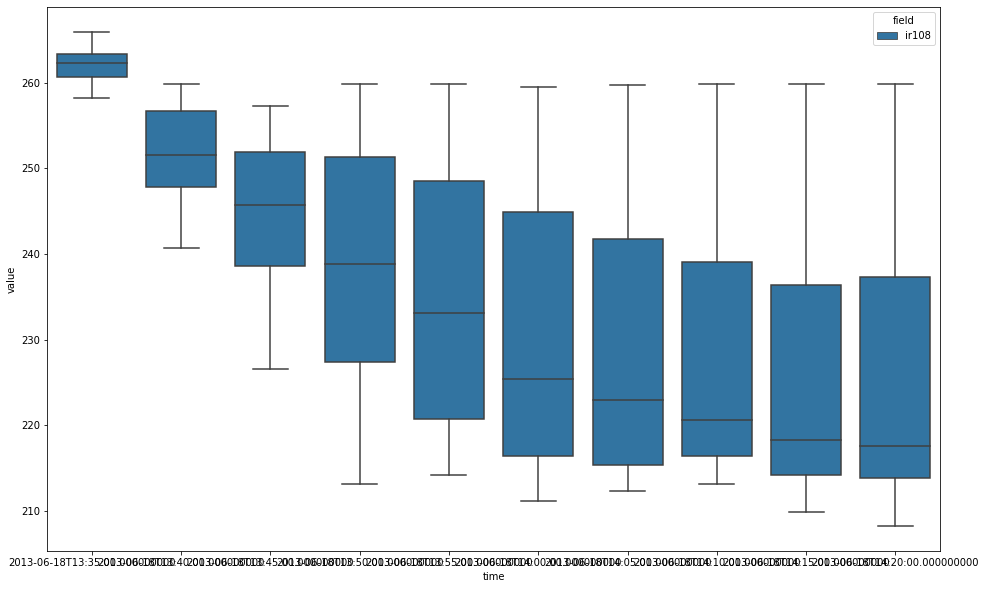

In [112]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
sns.boxplot(x='time',y='value',hue='field',data=ir108_df,ax=ax)

## Andere Ansatz

Hartwig ist die Watershedsegmentierung für diesen "einfachen" Fall zu viel. Deshalb ein Versuch mit linear angepassten Schwellwerten.

Als maximalen Schwellwert setzen wir mal 240&thinsp;K. Wenn das Minimum im Ausschnitt kleiner ist, dann ist der Schwellwert <i>min</i>&thinsp;+&thinsp;8&thinsp;K.

In [111]:
def get_threshold(field,max_thresh,spread):
    field_min = np.min(field)
    spread = np.min((max_thresh-field_min,spread))
    
    return np.min((field_min+spread,max_thresh))

In [102]:
field_min = 228
max_thresh = 240
max_spread = 10

In [107]:
spread = np.min((max_thresh - field_min,max_spread))

In [108]:
np.min((field_min+spread,max_thresh))

238

In [112]:
thresholds = [get_threshold(ir,270,10) for ir in ir108_subset]

In [113]:
thresholds

[270.0,
 270.0,
 270.0,
 270.0,
 270.0,
 270.0,
 270.0,
 270.0,
 270.0,
 269.53110000000004,
 263.779,
 260.5259,
 254.6861,
 251.9267,
 243.9546,
 242.6139,
 241.2432,
 241.2432,
 238.1134,
 239.2706,
 236.93280000000001,
 236.6338,
 223.1087,
 224.25330000000002,
 221.1403,
 222.3308,
 223.1087,
 219.9198,
 218.2425,
 219.506,
 219.506,
 221.93710000000002,
 220.73690000000002,
 221.93710000000002,
 221.5403,
 221.5403,
 222.3308,
 221.93710000000002,
 221.5403,
 221.93710000000002,
 221.93710000000002,
 221.93710000000002,
 222.7213,
 223.4931,
 223.87460000000002,
 223.87460000000002,
 223.4931,
 223.4931]

In [151]:
thresh = np.arange(270,210,-10)
spreads = np.arange(0,11,1)

In [152]:
obj_mask = {t:{s:[] for s in spreads} for t in thresh}
thresholds = {t:{s:[] for s in spreads} for t in thresh}
for t in thresh:
    for s in spreads:
        for ir in ir108_subset:
            default = get_threshold(ir,t,s)

            mask = np.ma.masked_greater(ir,default)
            om = ~mask.mask*1
            
            l,nl = ndi.label(om)
            
            obj_mask[t][s].append(l)
            
            thresholds[t][s].append(default)

In [156]:
thresholds[20][10][18]

238.1134

In [117]:
norm = mpl.colors.Normalize(vmin=1, vmax=10)

In [118]:
linestyles = {270:(0,()),
              260:(0,(5,1)),
              250:(0,(5,2)),
              240:(0,(5,3)),
              230:(0,(5,4)),
              220:(0,(5,5))}

In [119]:
linelabel = ["{} K".format(t) for t in thresh]
spread_label = ["{} K".format(s) for s in np.arange(0,11,1)]

In [120]:
hourminuteFmt = mpl.dates.DateFormatter('%H:%MZ')

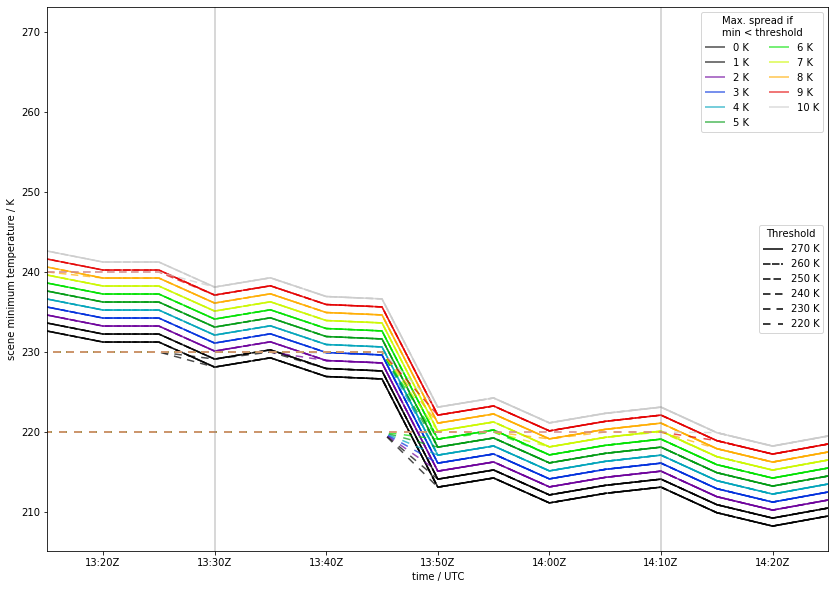

In [126]:
fig,ax = plt.subplots(1,1,figsize=(14,10))
for i,t in enumerate(thresholds.keys()):
    for j,s in enumerate(thresholds[t].keys()):
        p0 = ax.plot(sat_data.time.data,
                     thresholds[t][s],
                     c=mpl.cm.nipy_spectral(norm(j)),
                     linestyle=linestyles[t],
                     alpha=0.7)   

dummy_lines = []
for t_idx, t in enumerate(thresholds.keys()):
    dummy_lines.append(ax.plot([],[], c="black", ls = linestyles[t])[0])
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in spreads], 
                     spread_label, 
                     loc=1,
                     title="Max. spread if\nmin < threshold",
                     ncol=2)
legend2 = plt.legend([dummy_lines[i] for i,t in enumerate(thresholds.keys())], linelabel, loc=5, title="Threshold")
ax.add_artist(legend1)

ax.xaxis.set_major_formatter(hourminuteFmt)
ax.set_xlim(dt.datetime(2013,6,18,13,15),dt.datetime(2013,6,18,14,25))
ax.set_xlabel("time / UTC")
ax.set_ylabel("scene minimum temperature / K")

ax.axvline(dt.datetime(2013,6,18,13,30),c='gray',alpha=0.4)
ax.axvline(dt.datetime(2013,6,18,14,10),c='gray',alpha=0.4)  

In [85]:
ir108_subset[18].min()

228.1134

Im betrachteten Zeitraum ist das Minimum des Ausschnittes bereits kälter als 240&thinsp;K ({{ir108_subset[18].min()}}&thinsp;K) und sinkt auf unter 220&thinsp;K ({{ir108_subset[24].min()}}&thinsp;K). Um alle konvektiven Objekte zu erfassen, sollte also ein Schwellwert von 240&thinsp;K ausreichen. Selbst wenn der größte hier erfasste Wert für den Objektrand von Minimum&thinsp;+&thinsp;10&thinsp;K genutzt wird, bleibt der Randwert unter den von Hartwig angestrebten 240&thinsp;K. Also verwenden wir den.

In [145]:
connections,objects = ot.generate_graph_from_components(obj_mask[260][10][18:27].copy(),
                                                        np.arange(0,10))

In [144]:
data_segmented = obj_mask[260][10][18:27]

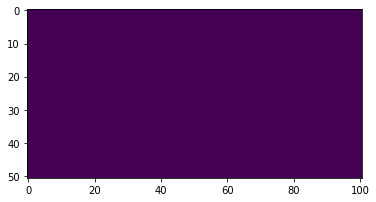

In [150]:
plt.imshow(data_segmented[0])

In [146]:
wanted_id = ot.get_wanted_object_id(data_segmented)
target_object_id = '{}_{:04d}'.format(len(data_segmented)//2,wanted_id)

# look for the graph wich cointains this object
wanted_object_graph = ot.get_wanted_graph(objects,target_object_id)

# it may be that this is a complex graph, but ideally we only want the
# path of a single cell
wanted_object_graph_sorted = ot.sort_graph_by_timesteps(wanted_object_graph)

object_track = ot.get_main_track(data_segmented,wanted_object_graph_sorted,target_object_id)

# get the objects
wanted_object = ot.get_wanted_objects(data_segmented,object_track)

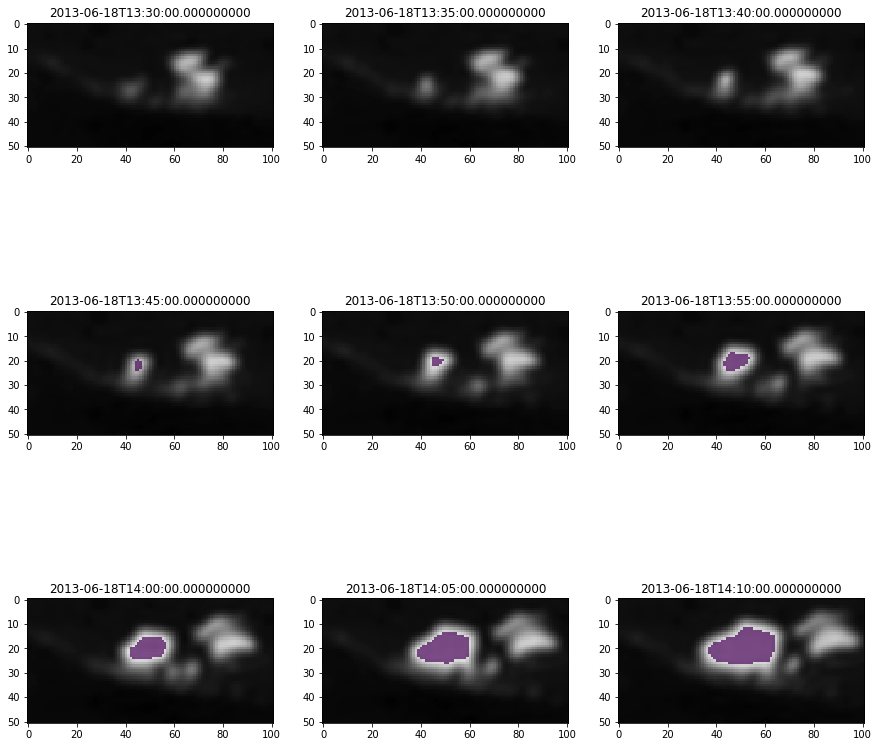

In [147]:
fig,ax = plt.subplots(3,3,figsize=(15,15))
axs = ax.ravel()

for i,o in enumerate(wanted_object):
    axs[i].imshow(ir108_subset[18:28][i],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(o,1),alpha=0.7)
    axs[i].set_title(sat_data.time.data[i+18])

Es zeigt sich, dass das Ausschnittsminimum zu Anfang des betrachteten Ausschnittes nicht von der gewünschten, sondern von einer Nachbarzelle stammt. Wir brauchen also doch die Watershedtransformation, um die Schwellwerte für die Objekte getrennt zu ermitteln.

In [54]:
ds = xr.Dataset(coords={'time': sat_data.time.data,
                        'lon': (['x', 'y'], sat_data.lon.data),
                        'lat': (['x', 'y'], sat_data.lat.data)})

In [55]:
for t in obj_mask.keys():
    for s in obj_mask[t].keys():
        label = "object_mask_{}_{}".format(t,s)
        da = xr.DataArray(obj_mask[t][s],
                          dims=['time','hx','hy'])

        ds[label] = da
        ds[label].attrs['units'] = 1
        ds[label].attrs['summary'] = "object mask for T={} K and spread of {} K.".format(t,s)

In [56]:
ds.attrs['title'] = "Object mask for different threshold settings for the example case for the HRV paper"
ds.attrs['institution'] = "Leibniz Institute for Tropospheric Research"
ds.attrs['contact_person'] = "Stephan Lenk, lenk@tropos.de"
ds.attrs['processing_time'] = pd.Timestamp.now().strftime("%Y%m%dT%H:%M:%S")
ds.attrs['author'] = "Stephan Lenk, lenk@tropos.de"
ds.attrs['license'] = "For non-commercial use only."
ds.attrs['source'] = "MSG SEVIRI data"
ds.attrs['history'] = "Compilation of HRIT data into NetCDF4 file"
ds.attrs['summary'] = "Object mask for different threshold settings"
ds.attrs['region_id'] = "eu"
ds.attrs['spatial_resolution'] = "3 km x 3km"
ds.attrs['gdal_projection'] = u'+proj=stere +lat_0=90 +lat_ts=60 +lon_0=10 ' +\
                              u'+x_0=0 +y_0=0 +a=6370.040 +b=6370.040 +units=km'

In [57]:
ds.to_netcdf("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")
ds.close()